# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)#set  random seed for reproducability
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Load Data and Merge

In [2]:
arrest_data = pd.read_csv("arrests_w_census_loc.csv")
arrest_data.PERP_RACE[arrest_data.PERP_RACE.str.contains("WHITE")]=0
arrest_data.PERP_RACE[arrest_data.PERP_RACE != 0]=1
arrest_data = arrest_data.groupby(["PERP_RACE","BlockLocation"]).size().reset_index(name='counts')
blockLocation = arrest_data["BlockLocation"]
blockLat = [float(re.findall(r'[-\d\.]+', bl)[0]) for bl in blockLocation]
blockLon = [float(re.findall(r'[-\d\.]+', bl)[1]) for bl in blockLocation]
arrest_data["blockLat"]=blockLat
arrest_data["blockLon"]=blockLon
arrest_data = arrest_data.drop("BlockLocation", axis=1)
arrest_data = arrest_data.rename(columns={"counts": "Num_Arrests", "PERP_RACE": "Race"})
block_data = pd.read_csv("census_block_loc.csv")
block_data = pd.merge(left=arrest_data, right=block_data,
                      left_on=["blockLat","blockLon"], right_on=["Latitude","Longitude"])
census_data = pd.read_csv("nyc_census_tracts.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
block_data = block_data.drop(columns=["Latitude","Longitude","BlockCode","County","blockLat","blockLon"])
data = pd.merge(left=block_data, right=census_data, left_on="tracts", right_on="CensusTract")
data = data.drop("tracts", axis=1)
data = data.drop("State", axis=1)
data

C:\Users\TestAccount\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\TestAccount\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Race,Num_Arrests,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
1,0,4,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
2,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
3,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
4,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11336,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11337,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11338,1,2,36005044800,Bronx,Bronx,2181,1092,1089,9.9,1.6,...,2.8,0.0,0.0,49.0,1233,77.9,19.6,2.5,0.0,10.7
11339,1,5,36005043000,Bronx,Bronx,3321,1380,1941,16.2,2.2,...,5.5,0.0,0.0,38.2,1466,76.2,22.4,1.4,0.0,9.5


# Remove Outlier Locations

There are 11341 Samples Before Outlier Removal


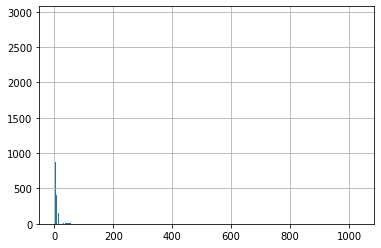

There are 10735 Samples After Outlier Removal


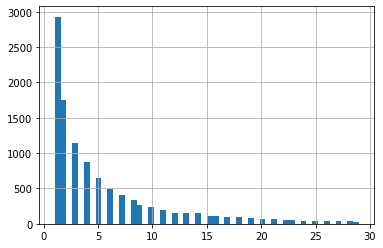

94.65655585927166% of Samples were Kept


In [3]:
data["Num_Arrests"].hist(bins='auto')
data_size=data.shape[0]
print("There are",data_size,"Samples Before Outlier Removal")
plt.show()
#cuttoff data after 20
data = data[data["Num_Arrests"]<30]
new_size=data.shape[0]
print("There are",new_size,"Samples After Outlier Removal")
data["Num_Arrests"].hist(bins='auto')
plt.show()
print(100*new_size/data_size,"% of Samples were Kept",sep="")

# Create Data Aggregates by County

In [4]:
def agg_all(data):
    new_data = {}
    for colname in ['Num_Arrests','TotalPop','Men','Women','Citizen','Income','IncomeErr', 'Employed']:
        new_data[colname]=data[colname].sum()
    for colname in ['Hispanic', 'White', 'Black', 'Native', 'Asian','IncomePerCap','IncomePerCapErr','Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
            'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk','OtherTransp', 'WorkAtHome',
           'MeanCommute','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']:
        ratio = data[colname]*data['TotalPop']
        new_data[colname]=(ratio.sum()/100)/data.size
    return pd.Series(new_data)

agg_data = data.groupby(['County','Race']).apply(agg_all)

# Attatch Aggregate to Data

In [5]:
agg_data["arrest_ratio"]=agg_data["Num_Arrests"]/agg_data["TotalPop"]
arrest_ratio = list(agg_data["arrest_ratio"])
county = list(agg_data.index.get_level_values(0))
race = list(agg_data.index.get_level_values(1))
agg_data = pd.DataFrame(arrest_ratio, columns=["arrest_ratio"])
agg_data["County"]=county
agg_data["Race"]=race
data = pd.merge(data, agg_data, on=["County","Race"])
data["County_Num_Arrests"]=data["arrest_ratio"]*data["TotalPop"]
data = data.drop("arrest_ratio", axis=1)
display(data.head())

,Race,Num_Arrests,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,County_Num_Arrests
0,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.147308
1,0,4,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.147308
2,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.147308
3,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.147308
4,0,1,36085024402,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3,2.147308


# Smooth Data Between Aggregate and Un-Aggregate

In [6]:
block_data = pd.read_csv("census_block_loc.csv")
block_data = block_data.drop(columns=["BlockCode","County","State"])
block_data["Raw_Arrests"]=np.random.normal(scale=10,size=block_data.shape[0])
block_data["County_Arrests"]=np.random.normal(scale=1,size=block_data.shape[0])
block_data["Smoothed_Arrests"]=np.random.normal(scale=5,size=block_data.shape[0])


# TODO: Visualize Num_Arrests, County_Num_Arrests, and Smoothed Version

In [ ]:
#put in visuals here from the dataset "block_data"
#real data will be replaced when Erik figures out the proper way to do the smoothing

# Apply Z Scaling to Continuous Features

In [7]:
num_cols = ['TotalPop','Men','Women','Hispanic','White','Black','Native','Asian','Citizen','Income','IncomeErr','IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service','Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome','MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']
X = data[num_cols].values
data.drop(columns=num_cols)
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_data = pd.DataFrame(X, columns=num_cols)
data[num_cols]=num_data
data = data.dropna()

# Split Data by Race and Into Train/Test Datasets

In [8]:
cols = data.shape[1]
data_white = data[data["Race"]==0].drop("Race", axis=1)
data_non_white=data[data["Race"]==1].drop("Race", axis=1)
data_white_train = data_white.sample(frac=0.8,random_state=101)
data_white_test  = data_white.drop(data_white_train.index)
data_non_white_train = data_non_white.sample(frac=0.8,random_state=101)
data_non_white_test  = data_non_white.drop(data_non_white_train.index)
Xw = data_white_train.iloc[:,1:cols]
yw = data_white_train.iloc[:,0]
Xnw = data_non_white_train.iloc[:,1:cols]
ynw = data_non_white_train.iloc[:,0]
Xwt = data_white_test.iloc[:,1:cols]
ywt = data_white_test.iloc[:,0]
Xnwt = data_non_white_test.iloc[:,1:cols]
ynwt = data_non_white_test.iloc[:,0]

# Encode Categorical Features as Numerical Values

In [9]:
cat_cols = ['CensusTract','County','Borough']
encoder = LabelEncoder()
for var in cat_cols:
    Xw[var] = encoder.fit_transform(Xw[var])
    Xnw[var] = encoder.fit_transform(Xnw[var])
    Xwt[var] = encoder.fit_transform(Xwt[var])
    Xnwt[var] = encoder.fit_transform(Xnwt[var])

# Initial Test of Nonlinear Kernels

In [10]:
rbfw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White RBF is",-sum(cv)/len(cv))

rbfnw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfnw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White RBF is",-sum(cv)/len(cv))

polyw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polyw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White Polynomial is",-sum(cv)/len(cv))

polynw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polynw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White Polynomial is",-sum(cv)/len(cv))

The average MSE for White RBF is 25.961481123505003
The average MSE for Non-White RBF is 42.32344659816731
The average MSE for White Polynomial is 25.814859067500542
The average MSE for Non-White Polynomial is 42.87101766355538


# Random Search to Tune Hyperparameters

In [11]:
params = {"C":[0.1,0.5,1,5,10,50,100,500,1000],"epsilon":uniform(1,3),"kernel":["poly","rbf"]}

rscv = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white C", rscv.best_estimator_.get_params()["C"])
print("optimal white epsilon", rscv.best_estimator_.get_params()["epsilon"])
print("optimal white kernel", rscv.best_estimator_.get_params()["kernel"])

rscv2 = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white C", rscv2.best_estimator_.get_params()["C"])
print("optimal non-white epsilon", rscv2.best_estimator_.get_params()["epsilon"])
print("optimal non-white kernel", rscv2.best_estimator_.get_params()["kernel"])


optimal white C 500
optimal white epsilon 1.0910448648414965
optimal white kernel rbf
optimal non-white C 1000
optimal non-white epsilon 2.6259597935782515
optimal non-white kernel rbf


# Run Test Data

In [12]:
Final_model = SVR(kernel='rbf', C=750, gamma="scale", epsilon=1.5)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  22.599631771725846
Test MAE for White:  2.922924840204984
Test MSE for Non-White:  31.391169452782947
Test MAE for Non-White:  3.8686288382759195


# Try Random Forrest

In [13]:
model = RandomForestRegressor()
model.fit(Xw, yw)
cv = cross_val_score(model, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White is",-sum(cv)/len(cv))
model.fit(Xnw, ynw)
cv = cross_val_score(model, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White is",-sum(cv)/len(cv))

C:\Users\TestAccount\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The average MSE for White is 21.09364132212654
The average MSE for Non-White is 32.210134068711675


# Tune Random Forrest Hyperparameters

In [18]:
params = {"min_samples_split":[2,5,10,15,20,25,30,35], "max_features":[5,10,15,20,25,30]}

rscv = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal min_samples_split", rscv.best_estimator_.get_params()["min_samples_split"])
print("optimal max_features", rscv.best_estimator_.get_params()["max_features"])

rscv2 = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal min_samples_split", rscv2.best_estimator_.get_params()["min_samples_split"])
print("optimal max_features", rscv2.best_estimator_.get_params()["max_features"])

optimal min_samples_split 25
optimal max_features 20
optimal min_samples_split 20
optimal max_features 5


# Predict Test Data From Best Model

In [19]:
Final_model = RandomForestRegressor(n_estimators=500, min_samples_split=25, max_features=10)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  19.381490716871955
Test MAE for White:  2.9939469565369548
Test MSE for Non-White:  23.471971846036553
Test MAE for Non-White:  3.6176315832912267


# Create Bias Metric

In [20]:
Final_model.fit(Xw, yw)
Xw["predicted_w"] = Final_model.predict(Xw)
Final_model.fit(Xnw, ynw)
Xnw["predicted_nw"] = Final_model.predict(Xnw)
Xnw = Xnw[["CensusTract", "predicted_nw"]]
X = pd.merge(left=Xw, right=Xnw,left_on="CensusTract", right_on="CensusTract")
X["Non-White"]=1-X["White"]
X["y"] = np.log(abs(X["predicted_w"]/X["White"]-X["predicted_nw"]/X["Non-White"]))
X = X.replace(np.inf, np.nan)
X = X.dropna()
X_train = X.sample(frac=0.8,random_state=101)
Xt=X.drop(X_train.index)
X=X_train
y = X["y"]
yt=Xt["y"]
X = X.drop(columns=['Hispanic','Black','Native','Asian',"White","Non-White","y"])
Xt = Xt.drop(columns=['Hispanic','Black','Native','Asian',"White","Non-White","y"])

# Fit Multi-Layer Perceptron To Bias Metric

In [21]:
model = Sequential()
model.add(Dense(50, input_dim = X.shape[1], activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_squared_error','mean_absolute_error'])
model.fit(X, y, epochs = 1000, batch_size = 16)

_, MSE, MAE = model.evaluate(Xt, yt)
print('MSE: ' + str(MSE) + ', MAE: '+ str(MAE))

Epoch 1/100
7982/7982 [==============================] - 0s 59us/step - loss: 231.3992 - mean_squared_error: 231.3993 - mean_absolute_error: 4.8388
Epoch 2/100
7982/7982 [==============================] - 0s 29us/step - loss: 0.9436 - mean_squared_error: 0.9436 - mean_absolute_error: 0.6663
Epoch 3/100
7982/7982 [==============================] - 0s 29us/step - loss: 0.8749 - mean_squared_error: 0.8749 - mean_absolute_error: 0.6375
Epoch 4/100
7982/7982 [==============================] - 0s 35us/step - loss: 0.8574 - mean_squared_error: 0.8574 - mean_absolute_error: 0.6301
Epoch 5/100
7982/7982 [==============================] - 0s 31us/step - loss: 0.8510 - mean_squared_error: 0.8510 - mean_absolute_error: 0.6296
Epoch 6/100
7982/7982 [==============================] - 0s 33us/step - loss: 0.8261 - mean_squared_error: 0.8261 - mean_absolute_error: 0.6156
Epoch 7/100
7982/7982 [==============================] - 0s 30us/step - loss: 0.8404 - mean_squared_error: 0.8404 - mean_absolute_er

7982/7982 [==============================] - 0s 31us/step - loss: 0.9577 - mean_squared_error: 0.9577 - mean_absolute_error: 0.6893
Epoch 58/100
7982/7982 [==============================] - 0s 28us/step - loss: 0.8360 - mean_squared_error: 0.8360 - mean_absolute_error: 0.6266
Epoch 59/100
7982/7982 [==============================] - 0s 28us/step - loss: 1.4349 - mean_squared_error: 1.4349 - mean_absolute_error: 0.8693
Epoch 60/100
7982/7982 [==============================] - 0s 32us/step - loss: 1.2237 - mean_squared_error: 1.2237 - mean_absolute_error: 0.7835
Epoch 61/100
7982/7982 [==============================] - 0s 28us/step - loss: 0.9782 - mean_squared_error: 0.9782 - mean_absolute_error: 0.6926
Epoch 62/100
7982/7982 [==============================] - 0s 29us/step - loss: 0.9603 - mean_squared_error: 0.9603 - mean_absolute_error: 0.6857
Epoch 63/100
7982/7982 [==============================] - 0s 28us/step - loss: 1.0657 - mean_squared_error: 1.0657 - mean_absolute_error: 0.736

# Predict Bias of Test Sets

In [23]:
test_predicted = model.predict(Xt)
mse = mean_squared_error(yt, test_predicted)
print("Test MSE: ",mse)
mae = mean_absolute_error(yt, test_predicted)
print("Test MAE: ",mae)

Test MSE:  1.533967943681707
Test MAE:  1.0131087721948757


# Create Dataset to Visualize Smoothing

In [24]:
block_data = pd.read_csv("census_block_loc.csv")
block_data = block_data.drop(columns=["BlockCode","County","State"])
block_data["Raw_Bias"]=np.random.normal(scale=10,size=block_data.shape[0])
block_data["County_Bias"]=np.random.normal(scale=1,size=block_data.shape[0])
block_data["Smoothed_Bias"]=np.random.normal(scale=5,size=block_data.shape[0])

# Visualize Smoothing

In [ ]:
#put in visuals here from the dataset "block_data"
#real data will be replaced when Erik figures out the proper way to do the smoothing